In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle as pkl
#import urllib.request # to fetch data online
#import re # regular expressions to parse html
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import lda_solved as lda

import seaborn as sns
sns.set(style="ticks");

In [2]:
# notebook specifics
%pylab inline
figsize(22,6)
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


# Latent Dirichlet allocation

Let $\alpha,\gamma>0$ be fixed, and consider the collapsed model given by Equations (27.33-27.36) of [Murphy, 2012, Section 27.3.4], with $\alpha_k=\alpha$ and $\gamma_k=\gamma$ for all $k$. I will stick to the notation of the book.

<font color='blue'> 
    **Question ($\star$):** What is the state space? 
</font> 

<font color='red'> 
    **Answer:** A state corresponds to all topic assignment variables $q_{i\ell}$ and all data variables $y_{i\ell}$. Formally 
    $$
    S = \prod_{i=1}^N (\{1,\dots,K\}\times \{1,\dots,V\})^{L_i},
    $$
    where $N$ is the number of documents, and $L_i$ the length of document $i$.
</font> 

<font color='blue'> 
    **Question ($\star$):** What is the effect of increasing $\alpha$? Of increasing $\gamma$? 
</font> 

<font color='red'> 
    **Answer:** Increasing $\alpha$ makes the central peak of the corresponding Dirichlet distribution sharper, resulting in more prior weight on flat-ish topic distributions $\pi_i$. Decreasing $\alpha$ allows the topic distribution within each document to have fewer atoms with large weights. $\gamma$ has the same effect, but for the word distribution in each topic.
</font> 

<font color='blue'> 
    **Question ($\star$):** Cite two Bayesian methods that you could use to fit such a model. Give one pro and one con for each method.
</font> 

<font color='red'> 
    **Answer:**  Gibbs, collapsed Gibbs, mean-field VB, gradient-based VB; see lectures.
</font> 

## Using collapsed Gibbs [Murphy, 2012, Section 27.3.4]
We want to implement collapsed Gibbs sampling. We start with the following small corpus of five documents.

In [3]:
corpus = ["Bayesian machine learning uses Monte Carlo methods",
         "Probability calculus is fundamental in Bayesian learning",
         "Machine learning is part of artificial intelligence",
         "The LOSC football team was champion last year",
         "The probability that LOSC beats Chelsea at football this year is small"]

<font color='blue'> 
    **Question ($\star\star$):** Complete function `CollapsedGibbs.run()` in `lda.py` to implement Eqn (27.37) of [Murphy, 2012, Section 27.3.4].
</font> 

In [4]:
# this should take less than a few seconds
gibbs = lda.CollapsedGibbs(corpus, num_topics=5, num_iterations=2000, seed=1)
gibbs.run()

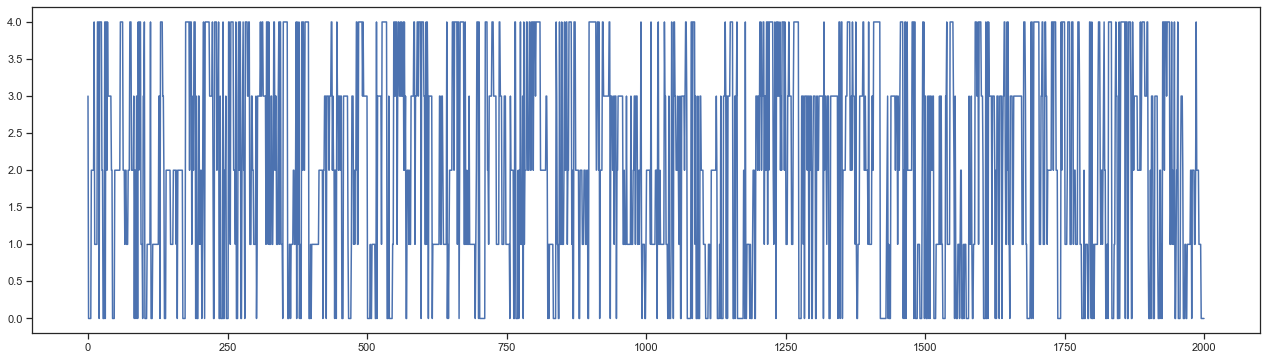

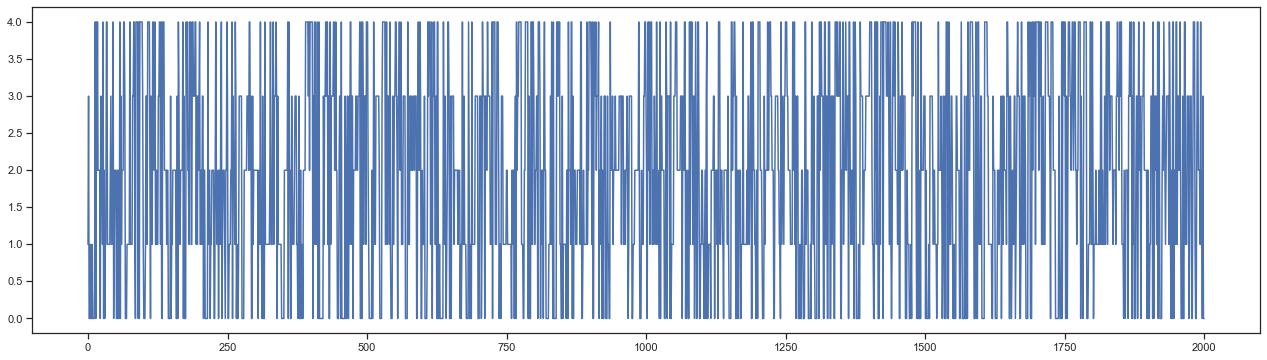

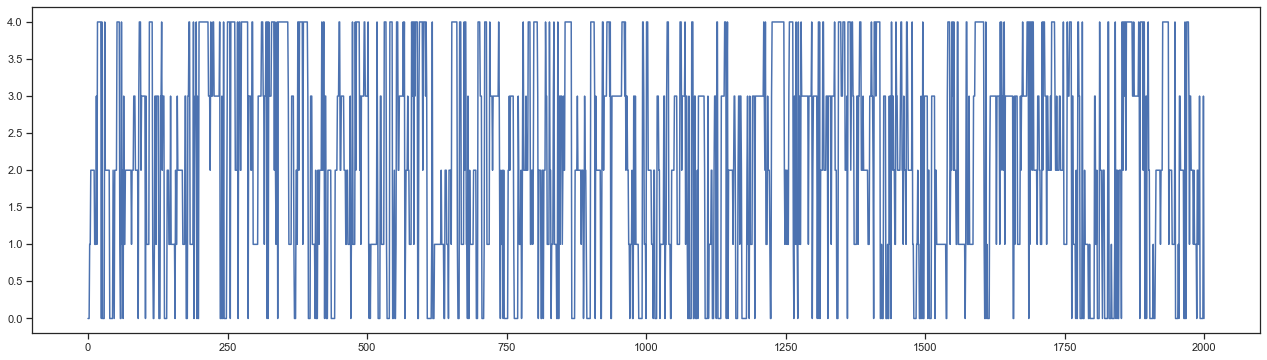

In [5]:
# Let us plot a few marginal chains, say the assignment of the first word of the first 3 documents
for i in range(3):
    plt.plot(gibbs.assign[i,0,:])
    plt.show()

<font color='blue'> 
    **Question ($\star$):** Given the trace plot above, do your chains look like they have mixed? i.e. do you reckon that you can trust the law of large numbers?
</font> 
<font color='red'> 
    **Question ($\star$):** Visually, nothing looks wrong: all chains seem to have visited the whole space multiple times.
</font> 


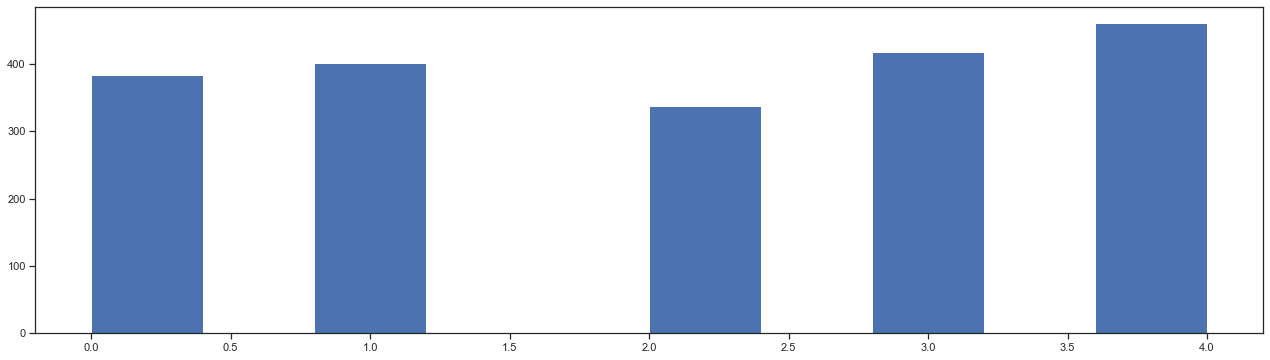

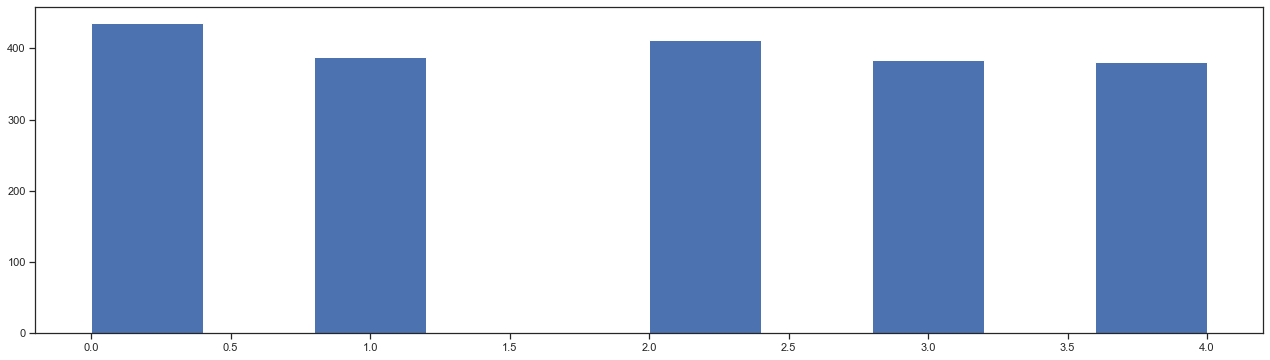

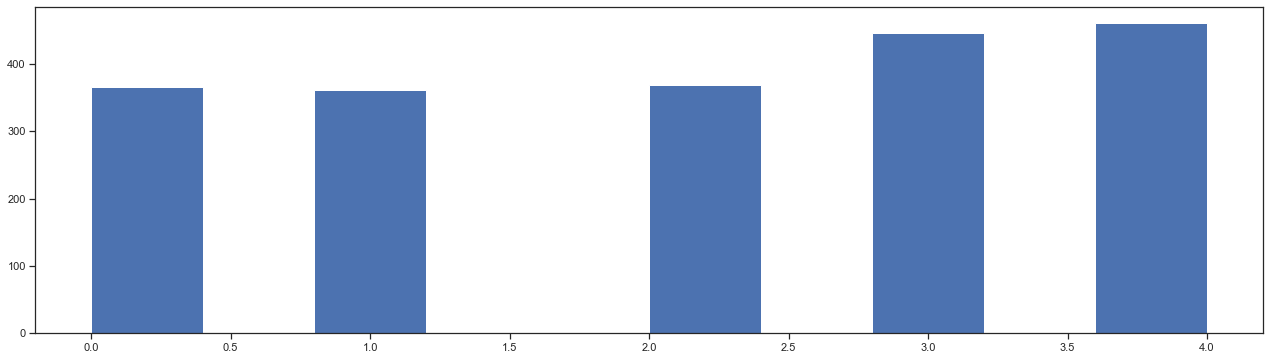

In [6]:
# Let us now plot the marginal histograms for the same assignment variables
for i in range(3):
    plt.hist(gibbs.assign[i,0,:])
    plt.show()

<font color='blue'> 
    **Question ($\star\star$):** What do you observe on these histograms? Why is it so?
</font> 

<font color='red'> 
    **Question ($\star\star$):** The joint model of LDA is invariant to permutations of the topics. This is why the posterior of marginal topic assignments is flat. In other words, neither the likelihood nor the prior change when we relabel the topics, so that the posterior has $K!$ copies of each mode! This phenomenon is called *label switching*. As a consequence, it is meaningless to ask questions that depend on the order of the topics, unless one destroys the symmetry by requiring, for instance, that topics are ordered by size, like the number of words that appear with probability larger than $1/2$. But this requires to abandon collapsed Gibbs sampling and come back to the original Gibbs sampling that includes the word distribution matrix $B$.
 </font> 

<font color='blue'> 
**Question ($\star\star\star$):** Still, we can ask questions that do not depend on the order of the variables. For instance, we want to know what pairs of documents share at least one topic. Find a loss function, give the Bayes action, and implement your solution. Explain all steps of your reasoning in detail.
</font> 

<font color='red'> 
    **Answer:** To know whether document $i$ and $j$ have a topic in common, one natural loss function could be a 0-1 loss. More precisely, the states are made of all $z_{i\ell}$ and $y_{i\ell}$ variables, for all $i$ and $\ell$. Actions are functions 
    $$
    \{ a_g:s \mapsto g(s); g:\mathcal{D}\rightarrow \{0,1\}  \},
    $$
    where $\mathcal{D}$ is the space where data live, i.e. $\{1,\dots,V\}^{L_1}\times \dots\times \{1,\dots,V\}^{L_N}$, and
    where we think of $a_g(s)=1$ as answering by "yes" to the original question. 
    Then we define 0-1 loss function as
    $$ 
    L(a_g,s) = (1-a_g(s)) 1_{\sum_{k=1}^K f(\mathbf z, k)>0} + a_g(s) 1_{\sum_{k=1}^K f(\mathbf z, k)=0}
    $$
    where $f(\mathbf z, k)$ is zero if topic $k$ appears in both documents $i$ and $j$, and $1$ otherwise. 
    Note that the loss function is invariant to permutations of the topic numbers.
    The Bayes action is thus to say "yes" whenever the posterior probability of
    $$
    \sum_{k=1}^K f(\mathbf z, k) > 0
    $$
    is larger than $1/2$. Let us plot our estimate of this posterior probability for all pairs of documents.
</font> 

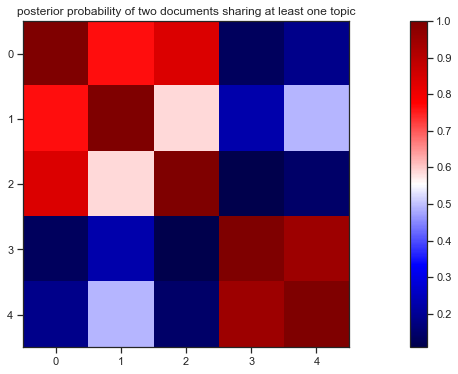

For reference, the corpus is
Document 0 : ['bayesian', 'machine', 'learning']
Document 1 : ['probability', 'bayesian', 'learning']
Document 2 : ['machine', 'learning']
Document 3 : ['losc', 'football', 'year']
Document 4 : ['probability', 'losc', 'football', 'year']


In [8]:
N = gibbs.num_documents
coincidence_matrix = np.zeros((N, N))
for i, doc in enumerate(gibbs.corpus):
    for j, doc in enumerate(gibbs.corpus):
        coincidence_matrix[i,j] = np.mean([np.any([
                      (k in gibbs.assign[i,:,t]) and (k in gibbs.assign[j,:,t]) # is topic k in both documents?
                      for k in range(gibbs.num_topics) # for at least one topic k
                      ]) for t in range(gibbs.num_iterations+1) # average across the chain to compute the posterior
              ])
plt.imshow(coincidence_matrix, cmap="seismic")
plt.colorbar()
plt.title("posterior probability of two documents sharing at least one topic") 
plt.show()

print("For reference, the corpus is")
for index, doc in enumerate(gibbs.corpus):
    print("Document", index, ":", doc)

<font color='red'> 
    **Answer:** One clearly sees the two clusters ("ML" and "football") as red-ish squares, as well as the clear outlier that is the fourth document, while the fifth shares some information with the second.
</font>

## Bonus question: variational inference

<font color='blue'> 
**Question:** Use either `scikit-learn` or `pymc3` to perform LDA using variational inference. Explain what methods are implemented under the hood, and investigate how the method scales to larger corpuses. Compare to how Gibbs sampling scales.
</font>  